In [11]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_excel("initial_data/nipt_data.xlsx")
print(df.head())

   序号  孕妇代码  年龄     身高    体重                 末次月经 IVF妊娠      检测日期  检测抽血次数  \
0   1  A001  31  160.0  72.0  2023-02-01 00:00:00  自然受孕  20230429       1   
1   2  A001  31  160.0  73.0  2023-02-01 00:00:00  自然受孕  20230531       2   
2   3  A001  31  160.0  73.0  2023-02-01 00:00:00  自然受孕  20230625       3   
3   4  A001  31  160.0  74.0  2023-02-01 00:00:00  自然受孕  20230716       4   
4   5  A002  32  149.0  74.0  2023-11-09 00:00:00  自然受孕  20240219       1   

    检测孕周  ...    Y染色体浓度    X染色体浓度  13号染色体的GC含量  18号染色体的GC含量  21号染色体的GC含量  \
0  11w+6  ...  0.025936  0.038061     0.377069     0.389803     0.399399   
1  15w+6  ...  0.034887  0.059572     0.371542     0.384771     0.391706   
2  20w+1  ...  0.066171  0.075995     0.377449     0.390582     0.399480   
3  22w+6  ...  0.061192  0.052305     0.375613     0.389251     0.397212   
4  13w+6  ...  0.059230  0.059708     0.380260     0.393618     0.404868   

   被过滤掉读段数的比例  染色体的非整倍体  怀孕次数  生产次数  胎儿是否健康  
0    0.027484       NaN     1     

In [12]:
df_male = df[df['Y染色体浓度'].notna()].copy()

def convert_ga_to_decimal(ga_str):
    """将“Xw+Y”格式转换为小数周（如11w+6 = 11 + 6/7 ≈ 11.86周）"""
    if pd.isna(ga_str):
        return np.nan
    # 拆分“周”和“天”部分，适配实际数据格式
    if 'w+' in str(ga_str):
        w_part, d_part = str(ga_str).split('w+')
    else:
        return np.nan  # 排除格式异常的孕周（如纯数字）
    try:
        return int(w_part) + int(d_part) / 7
    except (ValueError, IndexError):
        return np.nan

# 转换孕周并筛选10-25周样本
df_male['小数孕周'] = df_male['检测孕周'].apply(convert_ga_to_decimal)
df_male = df_male[(df_male['小数孕周'] >= 10) & (df_male['小数孕周'] <= 25)]

# 4. 测序质量筛选（C题.pdf附录1：GC含量正常范围40%~60%，对应真实列名“GC含量”（列16））
# 注意：数据中GC含量可能以小数形式呈现（如0.377069=37.7%），需先转换为百分比
df_male['GC含量_百分比'] = df_male['GC含量'] * 100
df_male = df_male[(df_male['GC含量_百分比'] >= 40) & (df_male['GC含量_百分比'] <= 60)]

# 5. 剔除Y染色体浓度异常值（C题.pdf4：男胎Y浓度达标值≥4%，数据中为小数（如0.025936=2.59%），合理范围0~15%）
df_male['Y染色体浓度_百分比'] = df_male['Y染色体浓度'] * 100
df_male = df_male[(df_male['Y染色体浓度_百分比'] >= 0) & (df_male['Y染色体浓度_百分比'] <= 15)]

# 6. 输出筛选结果（验证数据有效性）
print("=== 数据筛选结果 ===")
print(f"原始数据总样本数：{len(df)}")
print(f"男胎样本数（Y染色体浓度非空）：{len(df[df['Y染色体浓度'].notna()])}")
print(f"10-25周+正常GC的有效男胎样本数：{len(df_male)}")

# 7. 查看核心变量描述统计（贴合C题.pdf问题1的分析对象）
print("\n=== 核心变量描述统计（有效样本） ===")
core_vars = df_male[['Y染色体浓度_百分比', '小数孕周', '孕妇BMI']].rename(columns={
    'Y染色体浓度_百分比': 'Y染色体浓度(%)',
    '小数孕周': '孕周（小数）',
    '孕妇BMI': 'BMI'
})
print(core_vars.describe())

# 标记同一孕妇的多次检测（C题.pdf6：存在多次采血检测，对应真实列名“孕妇代码”（列2））
df_male['检测次数'] = df_male.groupby('孕妇代码')['检测日期'].cumcount() + 1  # 按检测日期排序标记次数

# 查看重复检测示例（以孕妇A001为例，匹配你提供的前3行数据）
print("\n=== 同一孕妇多次检测示例（孕妇A001） ===")
a001_data = df_male[df_male['孕妇代码'] == 'A001'][
    ['孕妇代码', '检测次数', '检测孕周', '小数孕周', 'Y染色体浓度_百分比', '孕妇BMI']
].sort_values('检测次数')

print(a001_data)

=== 数据筛选结果 ===
原始数据总样本数：1082
男胎样本数（Y染色体浓度非空）：1082
10-25周+正常GC的有效男胎样本数：519

=== 核心变量描述统计（有效样本） ===
        Y染色体浓度(%)      孕周（小数）         BMI
count  519.000000  519.000000  519.000000
mean     7.574064   16.120286   32.304640
std      2.916116    3.642887    2.747084
min      1.000389   11.000000   26.619343
25%      5.219353   13.142857   30.370302
50%      7.630164   15.571429   32.017138
75%      9.839118   17.857143   33.920238
max     14.825457   24.857143   46.875000

=== 同一孕妇多次检测示例（孕妇A001） ===
Empty DataFrame
Columns: [孕妇代码, 检测次数, 检测孕周, 小数孕周, Y染色体浓度_百分比, 孕妇BMI]
Index: []


In [13]:
# 1. 提取无缺失值的核心分析数据（排除筛选后仍存在的缺失值）
corr_data = df_male[['Y染色体浓度_百分比', '小数孕周', '孕妇BMI']].dropna()
print(f"\n=== 相关性分析数据概况 ===")
print(f"用于相关性计算的有效样本数：{len(corr_data)}")

# 2. 计算Pearson相关系数（检验线性相关，适配C题.pdf线性关系假设）
print("\n1. Pearson线性相关系数及显著性（α=0.05）")
print("-" * 60)
# Y染色体浓度与孕周的线性相关
pearson_ga, p_ga = pearsonr(corr_data['Y染色体浓度_百分比'], corr_data['小数孕周'])
print(f"Y染色体浓度(%) ↔ 孕周（小数）：")
print(f"  相关系数：{pearson_ga:.4f}")
print(f"  p值：{p_ga:.8f}（{'显著相关' if p_ga < 0.05 else '无显著相关'}）")

# Y染色体浓度与BMI的线性相关
pearson_bmi, p_bmi = pearsonr(corr_data['Y染色体浓度_百分比'], corr_data['孕妇BMI'])
print(f"\nY染色体浓度(%) ↔ 孕妇BMI：")
print(f"  相关系数：{pearson_bmi:.4f}")
print(f"  p值：{p_bmi:.8f}（{'显著相关' if p_bmi < 0.05 else '无显著相关'}）")

# 3. 计算Spearman秩相关系数（检验非线性相关，覆盖C题.pdf可能的非线性场景）
print("\n2. Spearman秩相关系数及显著性（α=0.05）")
print("-" * 60)
# Y染色体浓度与孕周的秩相关
spearman_ga, p_s_ga = spearmanr(corr_data['Y染色体浓度_百分比'], corr_data['小数孕周'])
print(f"Y染色体浓度(%) ↔ 孕周（小数）：")
print(f"  秩相关系数：{spearman_ga:.4f}")
print(f"  p值：{p_s_ga:.8f}（{'显著相关' if p_s_ga < 0.05 else '无显著相关'}）")

# Y染色体浓度与BMI的秩相关
spearman_bmi, p_s_bmi = spearmanr(corr_data['Y染色体浓度_百分比'], corr_data['孕妇BMI'])
print(f"\nY染色体浓度(%) ↔ 孕妇BMI：")
print(f"  秩相关系数：{spearman_bmi:.4f}")
print(f"  p值：{p_s_bmi:.8f}（{'显著相关' if p_s_bmi < 0.05 else '无显著相关'}）")


=== 相关性分析数据概况 ===
用于相关性计算的有效样本数：519

1. Pearson线性相关系数及显著性（α=0.05）
------------------------------------------------------------
Y染色体浓度(%) ↔ 孕周（小数）：
  相关系数：0.0160
  p值：0.71611045（无显著相关）

Y染色体浓度(%) ↔ 孕妇BMI：
  相关系数：-0.1356
  p值：0.00196836（显著相关）

2. Spearman秩相关系数及显著性（α=0.05）
------------------------------------------------------------
Y染色体浓度(%) ↔ 孕周（小数）：
  秩相关系数：0.0267
  p值：0.54412474（无显著相关）

Y染色体浓度(%) ↔ 孕妇BMI：
  秩相关系数：-0.1081
  p值：0.01375911（显著相关）



相关性散点图已保存为：Y浓度相关性分析图.png


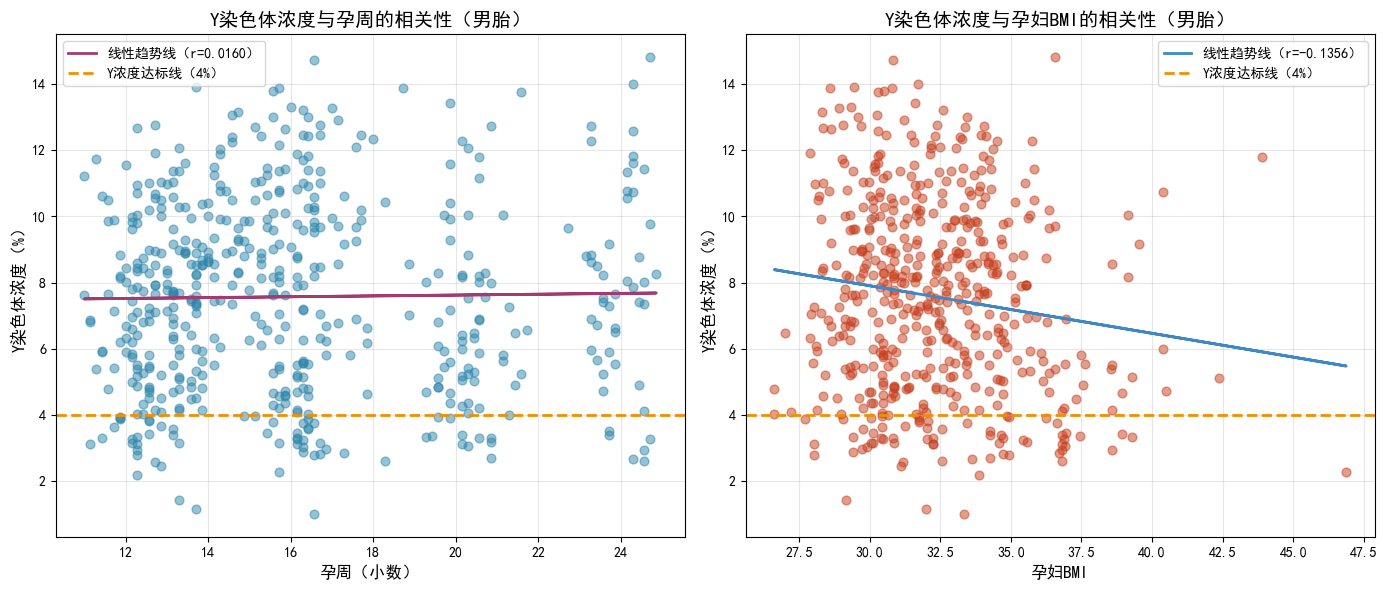

In [14]:
# 绘制Y染色体浓度与孕周、BMI的散点图（含趋势线，适配实际数据）
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 1. 左图：Y染色体浓度 vs 孕周（核心关联，C题.pdf重点分析对象）
ax1.scatter(corr_data['小数孕周'], corr_data['Y染色体浓度_百分比'], 
           alpha=0.5, color='#2E86AB', s=40)
# 添加线性趋势线
z1 = np.polyfit(corr_data['小数孕周'], corr_data['Y染色体浓度_百分比'], 1)
p1 = np.poly1d(z1)
ax1.plot(corr_data['小数孕周'], p1(corr_data['小数孕周']), 
         color='#A23B72', linewidth=2, label=f'线性趋势线（r={pearson_ga:.4f}）')
# 标注达标线（C题.pdf4：Y浓度≥4%为准确阈值）
ax1.axhline(y=4, color='#F18F01', linestyle='--', linewidth=2, label='Y浓度达标线（4%）')
ax1.set_xlabel('孕周（小数）', fontsize=12)
ax1.set_ylabel('Y染色体浓度（%）', fontsize=12)
ax1.set_title('Y染色体浓度与孕周的相关性（男胎）', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 右图：Y染色体浓度 vs BMI（关键影响因素，C题.pdf5重点提及）
ax2.scatter(corr_data['孕妇BMI'], corr_data['Y染色体浓度_百分比'], 
           alpha=0.5, color='#C73E1D', s=40)
# 添加线性趋势线
z2 = np.polyfit(corr_data['孕妇BMI'], corr_data['Y染色体浓度_百分比'], 1)
p2 = np.poly1d(z2)
ax2.plot(corr_data['孕妇BMI'], p2(corr_data['孕妇BMI']), 
         color='#3F88C5', linewidth=2, label=f'线性趋势线（r={pearson_bmi:.4f}）')
ax2.axhline(y=4, color='#F18F01', linestyle='--', linewidth=2, label='Y浓度达标线（4%）')
ax2.set_xlabel('孕妇BMI', fontsize=12)
ax2.set_ylabel('Y染色体浓度（%）', fontsize=12)
ax2.set_title('Y染色体浓度与孕妇BMI的相关性（男胎）', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 保存图片（便于论文呈现，符合C题.pdf论文格式规范）
plt.tight_layout()
plt.savefig("Y浓度相关性分析图.png", dpi=300, bbox_inches='tight')
print("\n相关性散点图已保存为：Y浓度相关性分析图.png")

图表已保存，警告已修复！

=== C题Y染色体浓度关键统计（按孕周分组） ===
         孕周分组  平均Y浓度（%）    标准差（%）  样本数
0  10-14周（早期）  7.187886  2.570186  197
1  15-19周（中期）  8.194636  3.127143  199
2  20-25周（晚期）  7.188562  2.933197  123


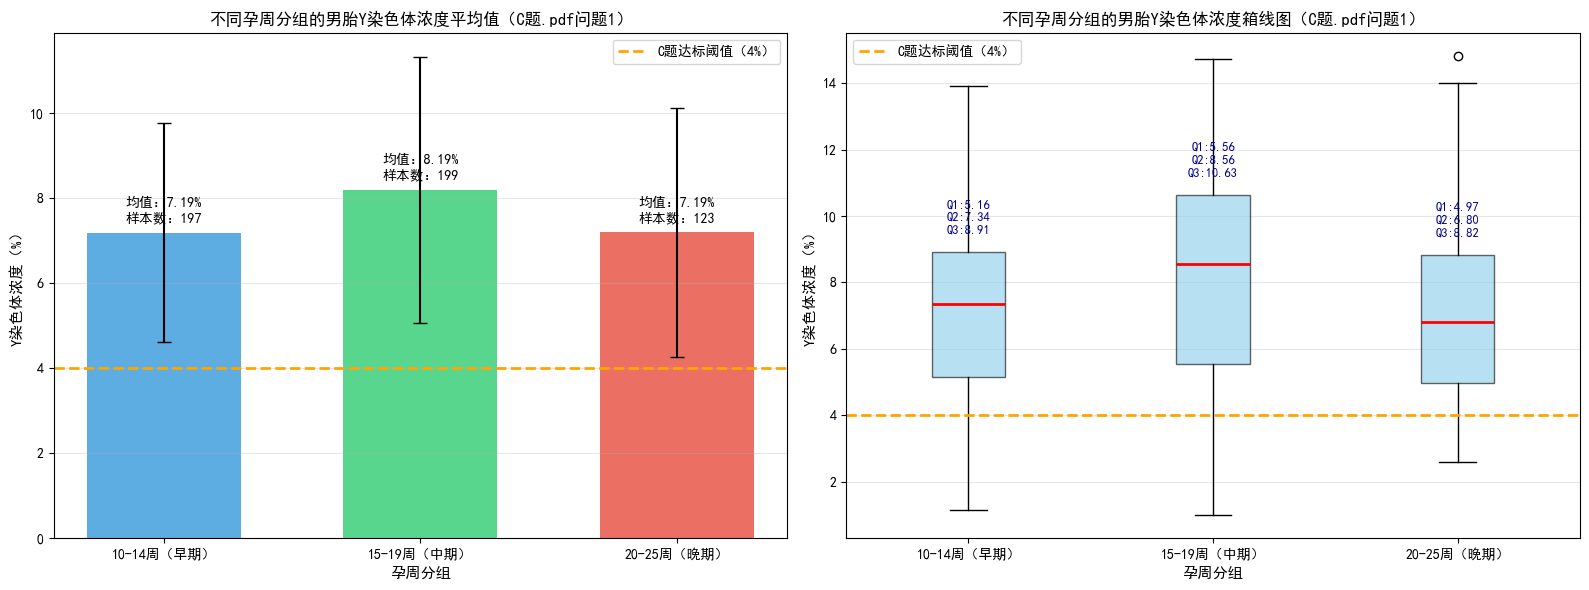

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

df = pd.read_excel("initial_data/nipt_data.xlsx")

# 2. 筛选男胎样本（C题.pdf4：男胎Y染色体浓度非空，女胎空白）
df_male = df[df['Y染色体浓度'].notna()].copy()

# 3. 孕周转换与筛选（C题.pdf4：仅10-25周可检测，转换为小数周）
def convert_ga_to_decimal(ga_str):
    if pd.isna(ga_str) or 'w+' not in str(ga_str):
        return np.nan
    w_part, d_part = str(ga_str).split('w+')
    try:
        return int(w_part) + int(d_part) / 7
    except:
        return np.nan
df_male['小数孕周'] = df_male['检测孕周'].apply(convert_ga_to_decimal)
df_male = df_male[(df_male['小数孕周'] >= 10) & (df_male['小数孕周'] <= 25)]

# 4. 测序质量筛选（C题.pdf附录1：GC含量40%-60%，转换为百分比）
df_male['GC含量_百分比'] = df_male['GC含量'] * 100
df_male = df_male[(df_male['GC含量_百分比'] >= 40) & (df_male['GC含量_百分比'] <= 60)]

# 5. 转换Y染色体浓度为百分比（C题.pdf4：达标阈值4%，数据为小数需转换）
df_male['Y染色体浓度_百分比'] = df_male['Y染色体浓度'] * 100
# 筛选合理浓度范围（0%-15%，排除测序错误）
df_male = df_male[(df_male['Y染色体浓度_百分比'] >= 0) & (df_male['Y染色体浓度_百分比'] <= 15)]

# 6. 按孕周分组（贴合C题.pdf“孕周影响Y浓度”的背景，用于分组可视化）
df_male['孕周分组'] = pd.cut(
    df_male['小数孕周'], 
    bins=[9.9, 14, 19, 25], 
    labels=['10-14周（早期）', '15-19周（中期）', '20-25周（晚期）']
)

# --------------------------
# 第二步：绘制Y染色体浓度图表（修复警告，核心逻辑不变）
# --------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ga_group_stats = df_male.groupby('孕周分组', observed=True)['Y染色体浓度_百分比'].agg([
    'mean', 'std', 'count'  # 均值、标准差、样本数（贴合C题.pdf数据统计需求）
]).reset_index()

# 绘制柱状图
x_pos = np.arange(len(ga_group_stats))
bars = ax1.bar(
    x_pos, 
    ga_group_stats['mean'], 
    width=0.6, 
    color=['#3498db', '#2ecc71', '#e74c3c'], 
    alpha=0.8,
    yerr=ga_group_stats['std'], 
    capsize=5
)

# 添加数值标签
for i, (bar, mean_val, count_val) in enumerate(zip(bars, ga_group_stats['mean'], ga_group_stats['count'])):
    ax1.text(
        bar.get_x() + bar.get_width()/2, 
        bar.get_height() + 0.2, 
        f'均值：{mean_val:.2f}%\n样本数：{count_val}', 
        ha='center', va='bottom', fontsize=10
    )

# 图表标注（贴合C题.pdf4中“Y浓度≥4%达标”的规则）
ax1.set_title('不同孕周分组的男胎Y染色体浓度平均值（C题.pdf问题1）', fontsize=12, fontweight='bold')
ax1.set_xlabel('孕周分组', fontsize=11)
ax1.set_ylabel('Y染色体浓度（%）', fontsize=11)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(ga_group_stats['孕周分组'], rotation=0)
ax1.axhline(y=4, color='orange', linestyle='--', linewidth=2, label='C题达标阈值（4%）')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

box_data = [
    df_male[df_male['孕周分组'] == '10-14周（早期）']['Y染色体浓度_百分比'].values,
    df_male[df_male['孕周分组'] == '15-19周（中期）']['Y染色体浓度_百分比'].values,
    df_male[df_male['孕周分组'] == '20-25周（晚期）']['Y染色体浓度_百分比'].values
]

# 绘制箱线图（关键修复：labels→tick_labels，消除MatplotlibDeprecationWarning）
box_plot = ax2.boxplot(
    box_data,
    tick_labels=['10-14周（早期）', '15-19周（中期）', '20-25周（晚期）'],  # 修复参数名
    patch_artist=True,
    boxprops=dict(facecolor='#87CEEB', alpha=0.6),
    medianprops=dict(color='red', linewidth=2),
    whiskerprops=dict(color='black', linewidth=1),
    capprops=dict(color='black', linewidth=1)
)

# 标注四分位数（贴合“四分卫图”需求，展示Q1、Q2、Q3）
for i, data in enumerate(box_data):
    q1 = np.percentile(data, 25)
    q2 = np.percentile(data, 50)
    q3 = np.percentile(data, 75)
    ax2.text(
        i+1, 
        q3 + 0.5, 
        f'Q1:{q1:.2f}\nQ2:{q2:.2f}\nQ3:{q3:.2f}',
        ha='center', va='bottom', fontsize=9, color='darkblue'
    )

# 图表标注（贴合C题.pdf问题1“分析Y浓度分布”的需求）
ax2.set_title('不同孕周分组的男胎Y染色体浓度箱线图（C题.pdf问题1）', fontsize=12, fontweight='bold')
ax2.set_xlabel('孕周分组', fontsize=11)
ax2.set_ylabel('Y染色体浓度（%）', fontsize=11)
ax2.axhline(y=4, color='orange', linestyle='--', linewidth=2, label='C题达标阈值（4%）')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# --------------------------
# 保存图表（符合C题.pdf论文格式规范）
# --------------------------
plt.tight_layout()
plt.savefig("C题_Y染色体浓度图表（柱状图+箱线图）.png", dpi=300, bbox_inches='tight')
print("图表已保存，警告已修复！")

# 输出关键统计结果（支撑C题.pdf问题1分析）
print("\n=== C题Y染色体浓度关键统计（按孕周分组） ===")
print(ga_group_stats[['孕周分组', 'mean', 'std', 'count']].rename(columns={
    'mean': '平均Y浓度（%）',
    'std': '标准差（%）',
    'count': '样本数'
}))